In [75]:
import numpy as np
import os
import copy
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
DATA_DIR = 'food11'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

BATCH_SIZE = 32
NUM_CLASSES = 11

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
def build_enum_dir(root_dir):
    """
    Создаёт список кортежей (имя_папки, индекс)
    на основе поддиректорий в root_dir.
    """
    folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    return [(folder, idx) for idx, folder in enumerate(folders)]

enum_dir = build_enum_dir(TRAIN_DIR)
print("📂 Найдены классы:")
for name, idx in enum_dir:
    print(f"{idx}: {name}")


def scan_and_clean_data(root_dir):
    """
    Сканирует корневую директорию с изображениями, автоматически определяет классы по именам подпапок,
    проверяет корректность файлов и возвращает пути к изображениям и их метки.

    Для каждой подпапки в `root_dir` создаётся уникальный числовой индекс (начиная с 0).
    Из каждой папки выбираются только корректные изображения форматов `.jpg` и `.jpeg`.
    """
    image_paths = []
    labels = []
    
    for label_name, label_id in enum_dir:
        path = os.path.join(root_dir, label_name)
                
        for filename in tqdm(os.listdir(path), desc=f"{label_name}"):
            file_path = os.path.join(path, filename)
            
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            
            try:
                img = Image.open(file_path)
                img.load()
                
                if img.mode not in ('RGB', 'L'):
                    continue

                image_paths.append(file_path)
                labels.append(label_id)
            except Exception:
                continue
    
    print(f"total {len(labels)}")
    for label_name, label_id in enum_dir:
        count = labels.count(label_id)
        print(f"{label_name:15s}: {count}")
        
    return image_paths, labels


for t in ['test', 'train']:
    print(f"\nПапка {t}")
    scan_and_clean_data(os.path.join(DATA_DIR, t))

📂 Найдены классы:
0: apple_pie
1: cheesecake
2: chicken_curry
3: french_fries
4: fried_rice
5: hamburger
6: hot_dog
7: ice_cream
8: omelette
9: pizza
10: sushi

Папка test


sushi: 100%|██████████| 100/100 [00:00<00:00, 326.66it/s]


total 1100
apple_pie      : 100
cheesecake     : 100
chicken_curry  : 100
french_fries   : 100
fried_rice     : 100
hamburger      : 100
hot_dog        : 100
ice_cream      : 100
omelette       : 100
pizza          : 100
sushi          : 100

Папка train


sushi: 100%|██████████| 900/900 [00:10<00:00, 88.55it/s]

total 9900
apple_pie      : 900
cheesecake     : 900
chicken_curry  : 900
french_fries   : 900
fried_rice     : 900
hamburger      : 900
hot_dog        : 900
ice_cream      : 900
omelette       : 900
pizza          : 900
sushi          : 900


## Вспомогательные функции

In [91]:
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    deivce,
    num_epochs=5,
    scheduler=None,
    f1_average="macro"
):
    """
    Универсальный цикл обучения для любых EfficientNet.

    Возвращает history с лоссами и метриками, чтобы можно было сравнить модели и обученную модель.
    """
    since = time.time()
    model = model.to(device)
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "test_loss": [],
        "test_acc": [],
        "test_f1": [],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        all_train_preds = []
        all_train_targets = []

        train_loop = tqdm(train_loader, desc="train", leave=False)
        for images, targets in train_loop:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            # Аккумулируем сумму ошибок для всех картинок.
            running_loss += loss.item() * images.size(0)
            # Считаем, сколько картинок в этом батче модель угадала правильно.
            running_corrects += torch.sum(preds == targets).item()
            total += targets.size(0)

            all_train_preds.extend(preds.detach().cpu().tolist())
            all_train_targets.extend(targets.detach().cpu().tolist())\

            current_acc = running_corrects / total if total > 0 else 0
            current_loss = running_loss / total if total > 0 else 0

            train_loop.set_postfix(Loss=f"{current_loss:.4f}", Acc=f"{current_acc:.4f}")

        epoch_train_loss = running_loss / total
        epoch_train_acc = running_corrects / total
        train_f1 = f1_score(all_train_targets, all_train_preds, average=f1_average)

        # Test
        model.eval()
        running_test_loss = 0.0
        running_test_corrects = 0
        test_total = 0
        all_test_preds = []
        all_test_targets = []

        with torch.no_grad():
            test_loop = tqdm(test_loader, desc="test", leave=False)
            for images, targets in test_loop:
                images = images.to(device)
                targets = targets.to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)

                _, preds = torch.max(outputs, 1)
                # Аккумулируем сумму ошибок для всех картинок.
                running_test_loss += loss.item() * images.size(0)
                # Считаем, сколько картинок в этом батче модель угадала правильно.
                running_test_corrects += torch.sum(preds == targets).item()
                test_total += targets.size(0)

                all_test_preds.extend(preds.detach().cpu().tolist())
                all_test_targets.extend(targets.detach().cpu().tolist())

                сurrent_test_acc = running_test_corrects / test_total if test_total > 0 else 0
                current_test_loss = running_test_loss / test_total if test_total > 0 else 0

                test_loop.set_postfix(Loss=f"{current_test_loss:.4f}", Acc=f"{сurrent_test_acc:.4f}")

        epoch_test_loss = running_test_loss / test_total
        epoch_test_acc = running_test_corrects / test_total
        test_f1 = f1_score(all_test_targets, all_test_preds, average=f1_average)

        if scheduler is not None:
            scheduler.step()

        print(
            f"train: loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} f1={train_f1:.4f}"
        )
        print(
            f"test: loss={epoch_test_loss:.4f} acc={epoch_test_acc:.4f} f1={test_f1:.4f}"
        )

        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["train_f1"].append(train_f1)
        history["test_loss"].append(epoch_test_loss)
        history["test_acc"].append(epoch_test_acc)
        history["test_f1"].append(test_f1)

    time_elapsed = time.time() - since
    print(f"Обучение завершено за {time_elapsed // 60:.0f}м {time_elapsed % 60:.0f}с")
    return history, model

In [79]:
def evaluate_model(model, data_loader, device, f1_average="macro"):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average=f1_average)
    return acc, f1, all_targets, all_preds

In [80]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    """
    Рисует confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)

    # подписи осей
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="Истинный класс",
        xlabel="Предсказанный класс",
        title="Confusion matrix",
    )

    # подписи в ячейках
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.show()

## EfficientNet-B0

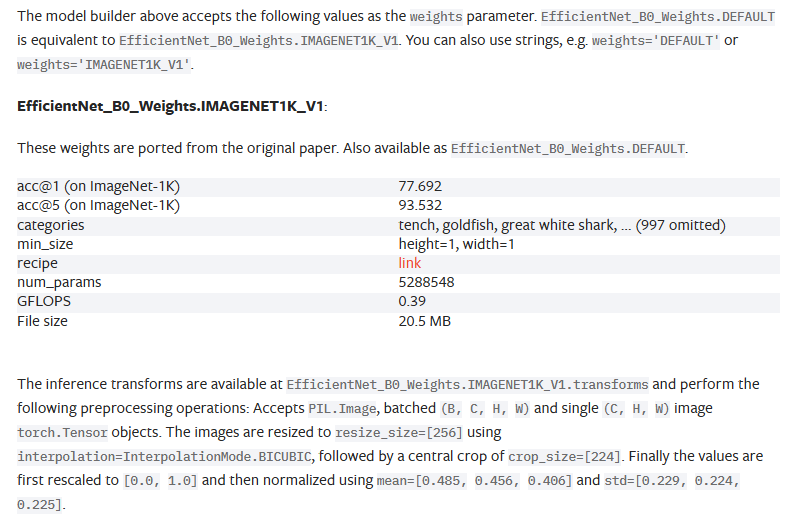

In [37]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [69]:
weights_b0 = EfficientNet_B0_Weights.IMAGENET1K_V1

test_transform_b0 = weights_b0.transforms()

train_transform_b0 = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224), # вместо center crop
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights_b0.transforms().mean,
                         std=weights_b0.transforms().std),
])

train_dataset_b0 = datasets.ImageFolder(TRAIN_DIR, transform=train_transform_b0)
test_dataset_b0 = datasets.ImageFolder(TEST_DIR, transform=test_transform_b0)

train_loader_b0 = torch.utils.data.DataLoader(train_dataset_b0, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader_b0 = torch.utils.data.DataLoader(test_dataset_b0, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [70]:
CLASS_NAMES = train_dataset_b0.classes
CLASS_NAMES

['apple_pie',
 'cheesecake',
 'chicken_curry',
 'french_fries',
 'fried_rice',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'omelette',
 'pizza',
 'sushi']

In [71]:
model_b0 = efficientnet_b0(weights=weights_b0)

for param in model_b0.features.parameters():
    param.requires_grad = False

num_features = model_b0.classifier[1].in_features
model_b0.classifier[1] = torch.nn.Linear(num_features, len(CLASS_NAMES))

model_b0 = model_b0.to(device)

loss = nn.CrossEntropyLoss()

# обучаем только параметры, у которых requires_grad=True
optimizer_b0 = optim.Adam(filter(lambda p: p.requires_grad, model_b0.parameters()), lr=0.001)

In [92]:
train_model_b0, history_b0 = train_model(
    model_b0,
    train_loader_B0,
    test_loader_B0,
    loss,
    optimizer_b0,
    device
)


Epoch 1/5


train: loss=0.9819 acc=0.6894 f1=0.6882
test: loss=0.8840 acc=0.7300 f1=0.7305

Epoch 2/5


train: loss=0.9770 acc=0.6861 f1=0.6848
test: loss=0.8901 acc=0.7300 f1=0.7307

Epoch 3/5


train: loss=0.9691 acc=0.6835 f1=0.6829
test: loss=0.8900 acc=0.7182 f1=0.7189

Epoch 4/5


train: loss=0.9466 acc=0.6908 f1=0.6897
test: loss=0.8821 acc=0.7245 f1=0.7259

Epoch 5/5


train: loss=0.9363 acc=0.7000 f1=0.6991
test: loss=0.9451 acc=0.7055 f1=0.7082
Обучение завершено за 24м 2с


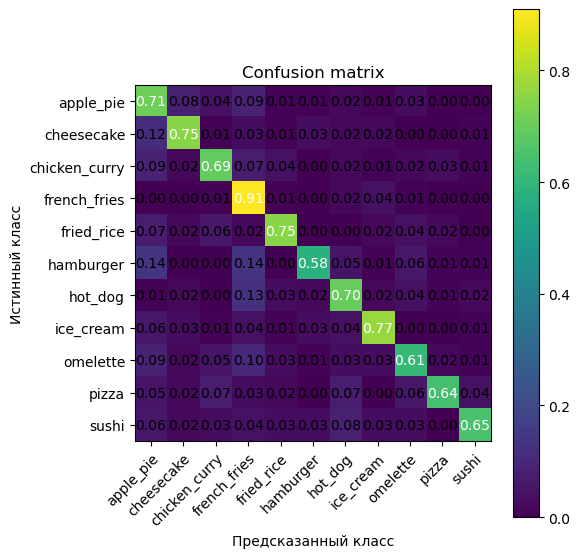

In [94]:
acc, f1, y_true, y_pred = evaluate_model(model_b0, test_loader_b0, device)

plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, normalize=True)
